In [21]:
from agricultural_csp.instance import *
from agricultural_csp.evaluator import *
from agricultural_csp.solution import *

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [22]:
%matplotlib widget

In [23]:
class InteractivePathBuilder:
    """
    Interactive plot for building custom paths by clicking on nodes.
    
    Controls:
    - Left click on grid: Add node to path
    - Right click on path node: Remove that node from path
    - 'c' key: Clear entire path
    - 'p' key: Print current path coordinates
    """
    
    def __init__(self, inst, evaluator):
        self.inst = inst
        self.evaluator = evaluator
        self.path = []
        self.fig, self.ax = plt.subplots(figsize=(14, 10))
        
        # Create a grid lookup for snapping clicks to nearest grid point
        self.grid_dict = {tuple(node): node for node in inst.grid_nodes}
        
        # Plot elements that will be updated
        self.grid_scatter = None
        self.covered_scatter = None
        self.covered_obstacles_scatter = None
        self.obstacle_scatter = None
        self.path_line = None
        self.path_markers = None
        self.start_marker = None
        self.end_marker = None
        
        # Text display for node list
        self.text_display = None
        
        self.setup_plot()
        self.connect_events()
        
    def setup_plot(self):
        """Initialize the plot with grid, obstacles, and empty path."""
        self.ax.clear()
        
        # Plot grid nodes
        self.grid_scatter = self.ax.scatter(
            self.inst.grid_nodes[:, 0], self.inst.grid_nodes[:, 1], 
            c='#AAAAAA', s=3, label='Grid Nodes', alpha=0.7, picker=True, pickradius=5
        )
        
        # Plot obstacles
        if hasattr(self.inst, 'obstacle_nodes') and len(self.inst.obstacle_nodes) > 0:
            self.obstacle_scatter = self.ax.scatter(
                self.inst.obstacle_nodes[:, 0], self.inst.obstacle_nodes[:, 1], 
                c='#CC0000', s=4, marker='s', label='Obstacles', linewidths=0.5
            )
        
        self.ax.axis('equal')
        self.ax.legend(loc='upper right', framealpha=0.9)
        self.ax.set_title('Interactive Path Builder - Click to add nodes | Right-click to remove | Press "c" to clear | Press "p" to print path', 
                         fontsize=11, fontweight='bold')
        
        # Add text box for displaying path info
        self.text_display = self.ax.text(
            0.02, 0.98, '', transform=self.ax.transAxes,
            verticalalignment='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        )
        
        # Don't call draw() here - let show() handle it
        
    def connect_events(self):
        """Connect matplotlib event handlers."""
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        self.fig.canvas.mpl_connect('key_press_event', self.on_key)
        
    def find_nearest_node(self, x, y):
        """Find the nearest grid node to the clicked position."""
        distances = np.sqrt((self.inst.grid_nodes[:, 0] - x)**2 + 
                          (self.inst.grid_nodes[:, 1] - y)**2)
        nearest_idx = np.argmin(distances)
        
        # Only return if click is reasonably close (within 1 unit)
        if distances[nearest_idx] < 1.5:
            return tuple(self.inst.grid_nodes[nearest_idx])
        return None
    
    def find_clicked_path_node(self, x, y):
        """Find if a path node was clicked for removal."""
        if len(self.path) == 0:
            return None
        
        path_arr = np.array(self.path)
        distances = np.sqrt((path_arr[:, 0] - x)**2 + (path_arr[:, 1] - y)**2)
        nearest_idx = np.argmin(distances)
        
        # Only return if click is close to a path node
        if distances[nearest_idx] < 1.5:
            return nearest_idx
        return None
        
    def on_click(self, event):
        """Handle mouse click events."""
        if event.inaxes != self.ax:
            return
            
        if event.button == 1:  # Left click - add node
            nearest_node = self.find_nearest_node(event.xdata, event.ydata)
            if nearest_node is not None:
                self.path.append(nearest_node)
                self.update_plot()
                print(f"Added node: {nearest_node} (Total: {len(self.path)} nodes)")
                
        elif event.button == 3:  # Right click - remove node
            node_idx = self.find_clicked_path_node(event.xdata, event.ydata)
            if node_idx is not None:
                removed_node = self.path.pop(node_idx)
                self.update_plot()
                print(f"Removed node: {removed_node} (Total: {len(self.path)} nodes)")
    
    def on_key(self, event):
        """Handle keyboard events."""
        if event.key == 'c':  # Clear path
            self.path = []
            self.update_plot()
            print("Path cleared!")
        elif event.key == 'p':  # Print path
            print("\n" + "="*50)
            print("Current Path:")
            print("="*50)
            for i, node in enumerate(self.path):
                print(f"  {i+1}. {node}")
            print(f"\nTotal nodes: {len(self.path)}")
            print("="*50 + "\n")
    
    def update_plot(self):
        """Redraw the plot with current path."""
        # Remove old path elements
        if self.path_line is not None:
            self.path_line.remove()
            self.path_line = None
        if self.path_markers is not None:
            self.path_markers.remove()
            self.path_markers = None
        if self.start_marker is not None:
            self.start_marker.remove()
            self.start_marker = None
        if self.end_marker is not None:
            self.end_marker.remove()
            self.end_marker = None
        if self.covered_scatter is not None:
            self.covered_scatter.remove()
            self.covered_scatter = None
        if self.covered_obstacles_scatter is not None:
            self.covered_obstacles_scatter.remove()
            self.covered_obstacles_scatter = None
        
        # Calculate coverage
        covered_nodes = []
        coverage_percentage = 0
        covered_obstacles = []
        hits_obstacle = False
        is_feasible = False
        
        if len(self.path) > 0:
            covered_nodes = self.evaluator.get_covered_nodes_list(self.path)
            total_nodes = self.inst.target_node_count
            covered_count = len(covered_nodes)
            coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
            
            # Check for obstacle coverage using the evaluator
            temp_solution = AgcspSolution(self.path)
            hits_obstacle = self.evaluator.hits_obstacle(temp_solution)
            is_feasible = self.evaluator.is_feasible(temp_solution)
            
            # Get list of covered obstacles for visualization
            if hasattr(self.inst, 'obstacle_nodes') and len(self.inst.obstacle_nodes) > 0:
                covered_set = set(map(tuple, covered_nodes))
                covered_obstacles = [obs for obs in self.inst.obstacle_nodes if tuple(obs) in covered_set]
            
            # Plot covered nodes
            if len(covered_nodes) > 0:
                self.covered_scatter = self.ax.scatter(
                    covered_nodes[:, 0], covered_nodes[:, 1], 
                    c='#00AA44', s=4, label='Covered Nodes', alpha=0.8, zorder=2
                )
            
            # Highlight covered obstacles
            if len(covered_obstacles) > 0:
                covered_obstacles_arr = np.array(covered_obstacles)
                self.covered_obstacles_scatter = self.ax.scatter(
                    covered_obstacles_arr[:, 0], covered_obstacles_arr[:, 1], 
                    c='#FF6600', s=15, marker='D', 
                    linewidths=2, label='⚠ Covered Obstacles', zorder=6
                )
        
        # Draw path
        if len(self.path) > 0:
            path_arr = np.array(self.path)
            
            # Path line
            self.path_line, = self.ax.plot(
                path_arr[:, 0], path_arr[:, 1], 
                color='#9900CC', linewidth=2, alpha=0.7, zorder=3
            )
            
            # Path markers
            self.path_markers = self.ax.scatter(
                path_arr[:, 0], path_arr[:, 1],
                c='#9900CC', s=50, marker='o', edgecolors='white',
                linewidths=1.5, zorder=4, label='Path Nodes'
            )
            
            # Start marker
            self.start_marker = self.ax.scatter(
                path_arr[0, 0], path_arr[0, 1],
                c='#00DD00', s=200, marker='*', 
                edgecolors='black', linewidths=2, zorder=5, label='Start'
            )
            
            # End marker (if more than one node)
            if len(self.path) > 1:
                self.end_marker = self.ax.scatter(
                    path_arr[-1, 0], path_arr[-1, 1],
                    c='#DD0000', s=100, marker='s',
                    edgecolors='black', linewidths=2, zorder=5, label='End'
                )
        
        # Update legend
        self.ax.legend(loc='upper right', framealpha=0.9)
        
        # Update text display with feasibility info
        text_content = f"Nodes in path: {len(self.path)}\n"
        if len(self.path) > 0:
            text_content += f"Coverage: {len(covered_nodes)}/{self.inst.target_node_count} ({coverage_percentage:.1f}%)\n"
            text_content += f"Path length: {self._calculate_path_length():.2f}\n"
            text_content += f"\n"
            
            # Feasibility status
            if is_feasible:
                text_content += "✓ FEASIBLE\n"
            else:
                text_content += "✗ NOT FEASIBLE\n"
            
            # Obstacle warning
            if hits_obstacle:
                text_content += f"⚠ Hits {len(covered_obstacles)} obstacles!\n"
            else:
                text_content += "✓ No obstacles hit\n"
            
            text_content += "\nLast 5 nodes:\n"
            for i, node in enumerate(self.path[-5:], start=max(1, len(self.path)-4)):
                text_content += f"  {i}. {node}\n"
        
        self.text_display.set_text(text_content)
        
        self.fig.canvas.draw()
    
    def _calculate_path_length(self):
        """Calculate total Euclidean length of the path."""
        if len(self.path) < 2:
            return 0.0
        
        path_arr = np.array(self.path)
        distances = np.sqrt(np.sum(np.diff(path_arr, axis=0)**2, axis=1))
        return np.sum(distances)
    
    def get_path(self):
        """Return the current path as a list of tuples."""
        return self.path.copy()
    
    def get_solution(self):
        """Return the current path as an AgcspSolution object."""
        if len(self.path) == 0:
            return None
        return AgcspSolution(self.path)
    
    def show(self):
        """Display the interactive plot."""
        plt.show()


def create_interactive_path_builder(inst, evaluator):
    """
    Create and display an interactive path builder.
    
    Args:
        inst: AgcspInstance object
        evaluator: AgcspEvaluator object
        
    Returns:
        InteractivePathBuilder object (path can be retrieved with .get_path())
    """
    builder = InteractivePathBuilder(inst, evaluator)
    builder.show()
    return builder

In [24]:
def display_grid_and_path(inst, evaluator, path):
    """
    Display a grid with nodes and path coverage visualization.
    
    Args:
        inst: AgcspInstance object containing grid_nodes and obstacle_nodes
        evaluator: AgcspEvaluator object to calculate coverage
        path: List of (row, col) tuples representing the path
    """
    covered_nodes = evaluator.get_covered_nodes_list(path)
    
    total_nodes = len(inst.field_nodes)
    covered_count = len(covered_nodes)
    coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Check for obstacle coverage
    covered_obstacles = []
    obstacle_warning = ""
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        covered_set = set(map(tuple, covered_nodes))
        covered_obstacles = [obs for obs in inst.obstacle_nodes if tuple(obs) in covered_set]
        if covered_obstacles:
            obstacle_warning = f" - {len(covered_obstacles)} obstacles covered!"
    
    plt.figure(figsize=(12, 10))
    
    # Plot valid nodes
    plt.scatter(inst.grid_nodes[:, 0], inst.grid_nodes[:, 1], c='#AAAAAA', s=3, 
               label='Uncovered Nodes', alpha=0.7)
    
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 0], covered_nodes[:, 1], c='#00AA44', s=4, 
                   label='Covered Nodes', alpha=0.8)
    
    # Plot obstacles
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        plt.scatter(inst.obstacle_nodes[:, 0], inst.obstacle_nodes[:, 1], c='#CC0000', s=4, 
                   marker='s', label='Obstacles', linewidths=0.5)
        
        # Highlight covered obstacles
        if covered_obstacles:
            covered_obstacles_arr = np.array(covered_obstacles)
            plt.scatter(covered_obstacles_arr[:, 0], covered_obstacles_arr[:, 1], 
                       c='#FF6600', s=10, marker='D', 
                       linewidths=2, label='Covered Obstacles')
    
    # Plot path
    if len(path) > 0:
        path_arr = np.array(path)
        plt.plot(path_arr[:, 0], path_arr[:, 1], color='#9900CC', linewidth=3, 
                label='Sprayer Path', marker='o', markersize=6, markerfacecolor='white', 
                markeredgecolor='#9900CC', markeredgewidth=2)
    
    # Plot start point (green star)
    if len(path) > 0:
        plt.scatter(path_arr[0, 0], path_arr[0, 1], c='#00DD00', s=200, 
                   marker='*', label='Start', edgecolors='black', linewidths=2, zorder=5)
    
    # Plot end point (red square)
    if len(path) > 1:
        plt.scatter(path_arr[-1, 0], path_arr[-1, 1], c='#DD0000', s=100, 
                   marker='s', label='End', edgecolors='black', linewidths=2, zorder=5)
    
    plt.axis('equal')
    plt.legend(loc='upper right', framealpha=0.9)
    
    title = f'Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%){obstacle_warning}'
    plt.title(title, fontsize=12, fontweight='bold')
    
    print(f"Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%)")
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        print(f"Obstacles: {len(covered_obstacles)}/{len(inst.obstacle_nodes)} covered")
        if covered_obstacles:
            print("WARNING: Sprayer is covering obstacles!")
    
    plt.show()

# Interactive Path Builder

Use the interactive tool below to create your own custom path:

**Controls:**
- **Left click** on any grid node to add it to your path
- **Right click** on a path node to remove it
- **Press 'c'** to clear the entire path
- **Press 'p'** to print the full path coordinates to console

The plot dynamically updates to show:
- Coverage statistics
- Path length
- **Feasibility status** (using `is_feasible` check)
- **Obstacle collision detection** (covered obstacles highlighted in orange)
- Last 5 nodes added

In [25]:
# Create a 50 x 50 square grid with five small square obstacles scattered on the grid
obstacle_half_size = 2  # Half-size of each small square obstacle

r_grid, c_grid = np.mgrid[0:50, 0:50]
grid_nodes = np.argwhere((r_grid >= 0) & (r_grid < 50) & (c_grid >= 0) & (c_grid < 50))

# Create five small square obstacles at different positions on the grid
obstacle_positions = [
    (10, 10),  # Top-left area
    (10, 40),  # Top-right area
    (25, 25),  # Center
    (40, 10),  # Bottom-left area
    (40, 40)   # Bottom-right area
]

obstacle_list = []
for obs_r, obs_c in obstacle_positions:
    obstacle = np.argwhere(
        (np.abs(r_grid - obs_r) <= obstacle_half_size) & 
        (np.abs(c_grid - obs_c) <= obstacle_half_size)
    )
    obstacle_list.append(obstacle)

obstacle_nodes = np.vstack(obstacle_list)
instance = AgcspInstance(grid_nodes, obstacle_nodes, 5, 90, adaptive_sampling=False)

evaluator = AgcspEvaluator(instance)

/home/everton/.local/lib/python3.10/site-packages/matplotlib/__init__.py:943: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  warnings.warn(self.msg_depr_ignore % (key, alt),


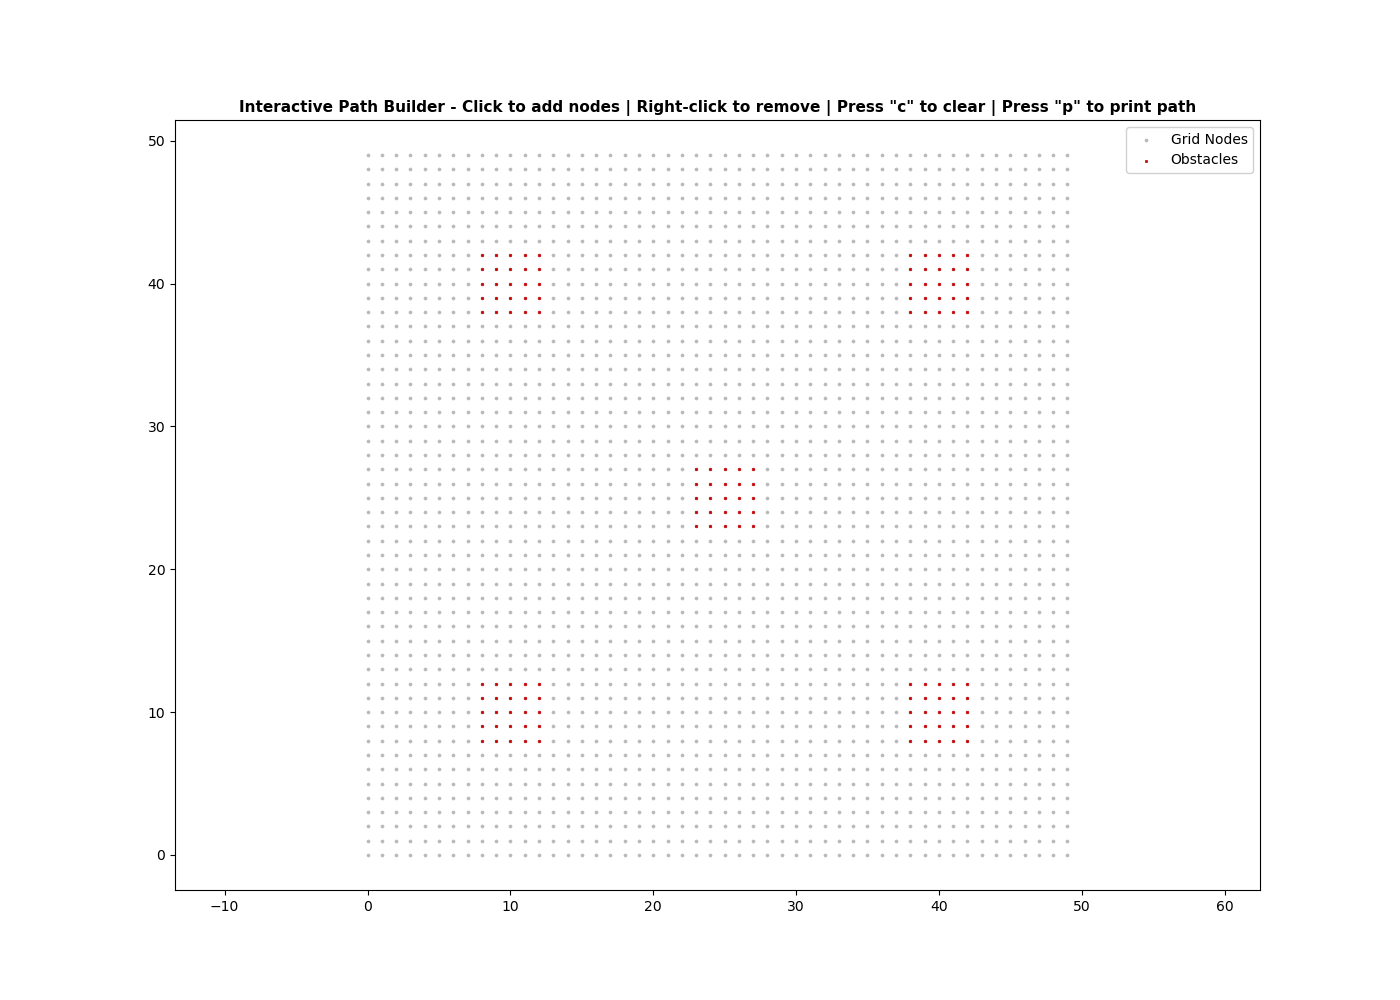

In [26]:
# Create interactive path builder
# Note: Use %matplotlib widget or %matplotlib notebook for better interactivity in Jupyter
# If you get static plots, run: %matplotlib widget

builder = create_interactive_path_builder(instance, evaluator)

In [27]:
# After closing the interactive plot, retrieve the path you created:
my_custom_path = builder.get_path()
my_custom_solution = builder.get_solution()

print(f"Created path with {len(my_custom_path)} nodes")

if my_custom_solution:
    print(f"\nFeasibility Check:")
    print(f"  Is feasible: {evaluator.is_feasible(my_custom_solution)}")
    print(f"  Hits obstacle: {evaluator.hits_obstacle(my_custom_solution)}")
    print(f"  Coverage: {evaluator.coverage_proportion(my_custom_solution)*100:.2f}%")
    print(f"  Path length: {evaluator.path_length(my_custom_solution):.2f}")
    print(f"  Objective value: {evaluator.objfun(my_custom_solution):.2f}")

Created path with 64 nodes

Feasibility Check:
  Is feasible: False
  Hits obstacle: False
  Coverage: 66.65%
  Path length: 362.49
  Objective value: 1207.84


In [28]:
import pickle

# Pickle the custom solution to a file
with open('clove_custom_solution.pkl', 'wb') as f:
    pickle.dump(my_custom_solution, f)

print("Solution saved to 'my_custom_solution.pkl'")

Solution saved to 'my_custom_solution.pkl'


# Working upon manual inital solution

In [1]:
from agricultural_csp.instance import *
from agricultural_csp.evaluator import *
from agricultural_csp.solver.agcsp_ts import *

In [29]:
import pickle

# Unpickle the custom solution from file
with open('clove_custom_solution.pkl', 'rb') as f:
    loaded_solution = pickle.load(f)

print(f"Loaded solution with {len(loaded_solution.path)} nodes")

Loaded solution with 64 nodes


In [30]:
strategy = TSStrategy(
    phased_optimization=PhasedOptimizationParams(phase_iterations=[10, 10, 10], degradation_tolerances=[0, 0, 0]),
    tabu_radius=3,
    search_strategy='first'
)

term_criteria = TerminationCriteria(max_iterations=300)
debug_options = DebugOptions(verbose=True)

ts = AgcspTS(instance, tenure=10, strategy=strategy, termination_criteria=term_criteria, debug_options=debug_options)

In [31]:
ts.solve(initial_solution=loaded_solution)

--- Iniciando TS com solução fornecida. ---
-----------------------------------------------------------
Initial solution objective value: 1207.84
-----------------------------------------------------------
Iteration 0: Best ObjFun = 1207.84, Current ObjFun = 1207.84
Applying move: move with args (28, array([ 0, 14]))
Iteration 1: Best ObjFun = 1198.79, Current ObjFun = 1198.79
Applying move: remove with args (46,)
Iteration 2: Best ObjFun = 1196.60, Current ObjFun = 1196.60
Applying move: move with args (42, array([ 0, 45]))
Iteration 3: Best ObjFun = 1196.60, Current ObjFun = 1198.12
Applying move: insert with args ((46, 11), 21)
Iteration 4: Best ObjFun = 1193.83, Current ObjFun = 1193.83
  >>> MOVE ACEITO (Swap): Indices (13, 55). Delta Total: -2.1809
Applying move: swap with args (13, 55)
Iteration 5: Best ObjFun = 1191.65, Current ObjFun = 1191.65
Applying move: insert with args ((33, 16), 25)
Iteration 6: Best ObjFun = 1191.05, Current ObjFun = 1191.05
Applying move: move with ar

AgcspSolution(path=[[22. 48.]
 [ 5. 49.]
 [ 3. 35.]
 [ 8. 30.]
 [24.  0.]
 [46.  0.]
 [49. 43.]
 [41. 45.]
 [34. 45.]
 [30. 48.]
 [24. 45.]
 [24. 45.]
 [21. 40.]
 [24. 38.]
 [45. 33.]
 [49. 45.]
 [47. 49.]
 [34. 47.]
 [34. 47.]
 [33. 47.]
 [31. 44.]
 [32. 43.]
 [38. 31.]
 [37. 27.]
 [30. 26.]
 [31. 18.]
 [28. 10.]
 [35.  6.]
 [34.  3.]
 [37.  0.]
 [47.  5.]
 [45. 10.]
 [44. 17.]
 [42. 18.]
 [40. 15.]
 [37. 15.]
 [34. 12.]
 [20. 16.]
 [ 4. 25.]
 [ 0. 22.]
 [ 0. 19.]
 [ 5. 11.]
 [ 2.  4.]
 [ 2.  2.]
 [ 4.  1.]
 [10.  5.]
 [14.  0.]
 [17.  2.]
 [15. 11.]
 [20. 25.]
 [18. 27.]
 [18. 27.]
 [21. 29.]
 [18. 35.]
 [15. 38.]
 [16. 42.]
 [17. 42.]
 [20. 42.]
 [20. 42.]
 [19. 46.]
 [ 8. 45.]
 [ 5. 47.]
 [ 1. 46.]
 [ 2. 35.]
 [17. 34.]
 [20. 31.]
 [20. 31.]
 [23. 33.]
 [33. 30.]
 [43. 29.]
 [44. 25.]
 [38. 21.]
 [19. 19.]
 [ 9. 15.]
 [ 6. 18.]
 [ 5. 19.]
 [ 3. 29.]
 [10. 31.]
 [17. 28.]
 [15. 22.]
 [30.  1.]
 [39.  5.]
 [48.  4.]
 [49.  0.]], cache_keys=['__hash', '_coverage_mask', 'hits_obstacle'

Coverage: 2252/2375 nodes (94.8%)
Obstacles: 0/125 covered


/home/everton/.local/lib/python3.10/site-packages/matplotlib/__init__.py:943: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  warnings.warn(self.msg_depr_ignore % (key, alt),


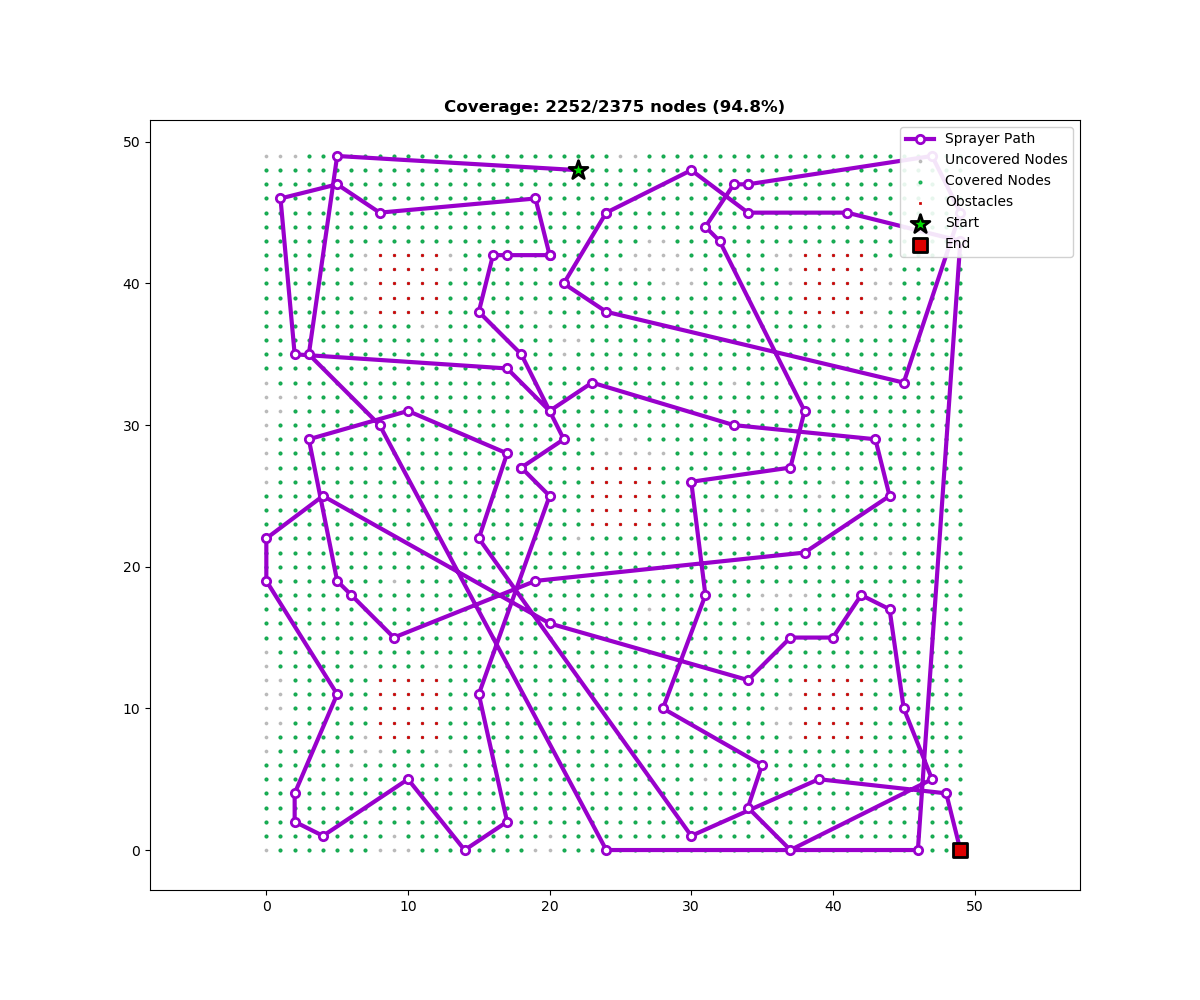

In [33]:
display_grid_and_path(instance, evaluator, ts.best_solution.path)